# Project Overview 📋
```
n this project, we aim to classify various dental conditions using deep learning techniques. The dataset consists of images of dental conditions like caries, calculus, gingivitis, ulcers, tooth discoloration, and hypodontia. We will train a Convolutional Neural Network (CNN) using the ResNet18 architecture to classify these conditions.
```

# Main Libraries

In [50]:
import os 
import shutil
from glob import glob
from PIL import Image

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Copy Images to folders Train | Test | Valid

In [51]:
original_dirs = {
    'Calculus': '/kaggle/input/oral-diseases/Calculus/Calculus',
    'Caries': '/kaggle/input/oral-diseases/Data caries/Data caries/caries augmented data set/preview',
    'Gingivitis': '/kaggle/input/oral-diseases/Gingivitis/Gingivitis',
    'Ulcers': '/kaggle/input/oral-diseases/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview',
    'Tooth Discoloration': '/kaggle/input/oral-diseases/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview',
    'Hypodontia': '/kaggle/input/oral-diseases/hypodontia/hypodontia'
} 
for class_name,path in original_dirs.items():
    print(f'Class Name --> {class_name} and total number of images {len(os.listdir(path))}')
    print()

base_dir='/kaggle/working/'

classes = list(original_dirs.keys())
splits = ['train','val','test']
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir,split,class_name),exist_ok=True)


for class_name,original_dir in original_dirs.items():
    image_paths=glob(os.path.join(original_dir,'*.*'))
    image_paths=[p for p in image_paths if p.lower().endswith(('.jpg','.jpeg','.png'))]

    train,test=train_test_split(image_paths,test_size=.1,random_state=42)
    train,val=train_test_split(train,test_size=.2,random_state=42)
    
    for split,paths in {'train':train,'val':val,'test':test}.items():
        for img_path in paths:
            shutil.copy(img_path,os.path.join(base_dir,split,class_name,os.path.basename(img_path)))
    print(f"{class_name}: {len(train)} train, {len(val)} val, {len(test)} test")
print("✅ Images have been copied and organized successfully.")



Class Name --> Calculus and total number of images 1296

Class Name --> Caries and total number of images 2382

Class Name --> Gingivitis and total number of images 2349

Class Name --> Ulcers and total number of images 2541

Class Name --> Tooth Discoloration and total number of images 1834

Class Name --> Hypodontia and total number of images 1251

Calculus: 932 train, 234 val, 130 test
Caries: 1714 train, 429 val, 239 test
Gingivitis: 1691 train, 423 val, 235 test
Ulcers: 1828 train, 458 val, 255 test
Tooth Discoloration: 1320 train, 330 val, 184 test
Hypodontia: 900 train, 225 val, 126 test
✅ Images have been copied and organized successfully.


# Displaying Random Images 🖼️


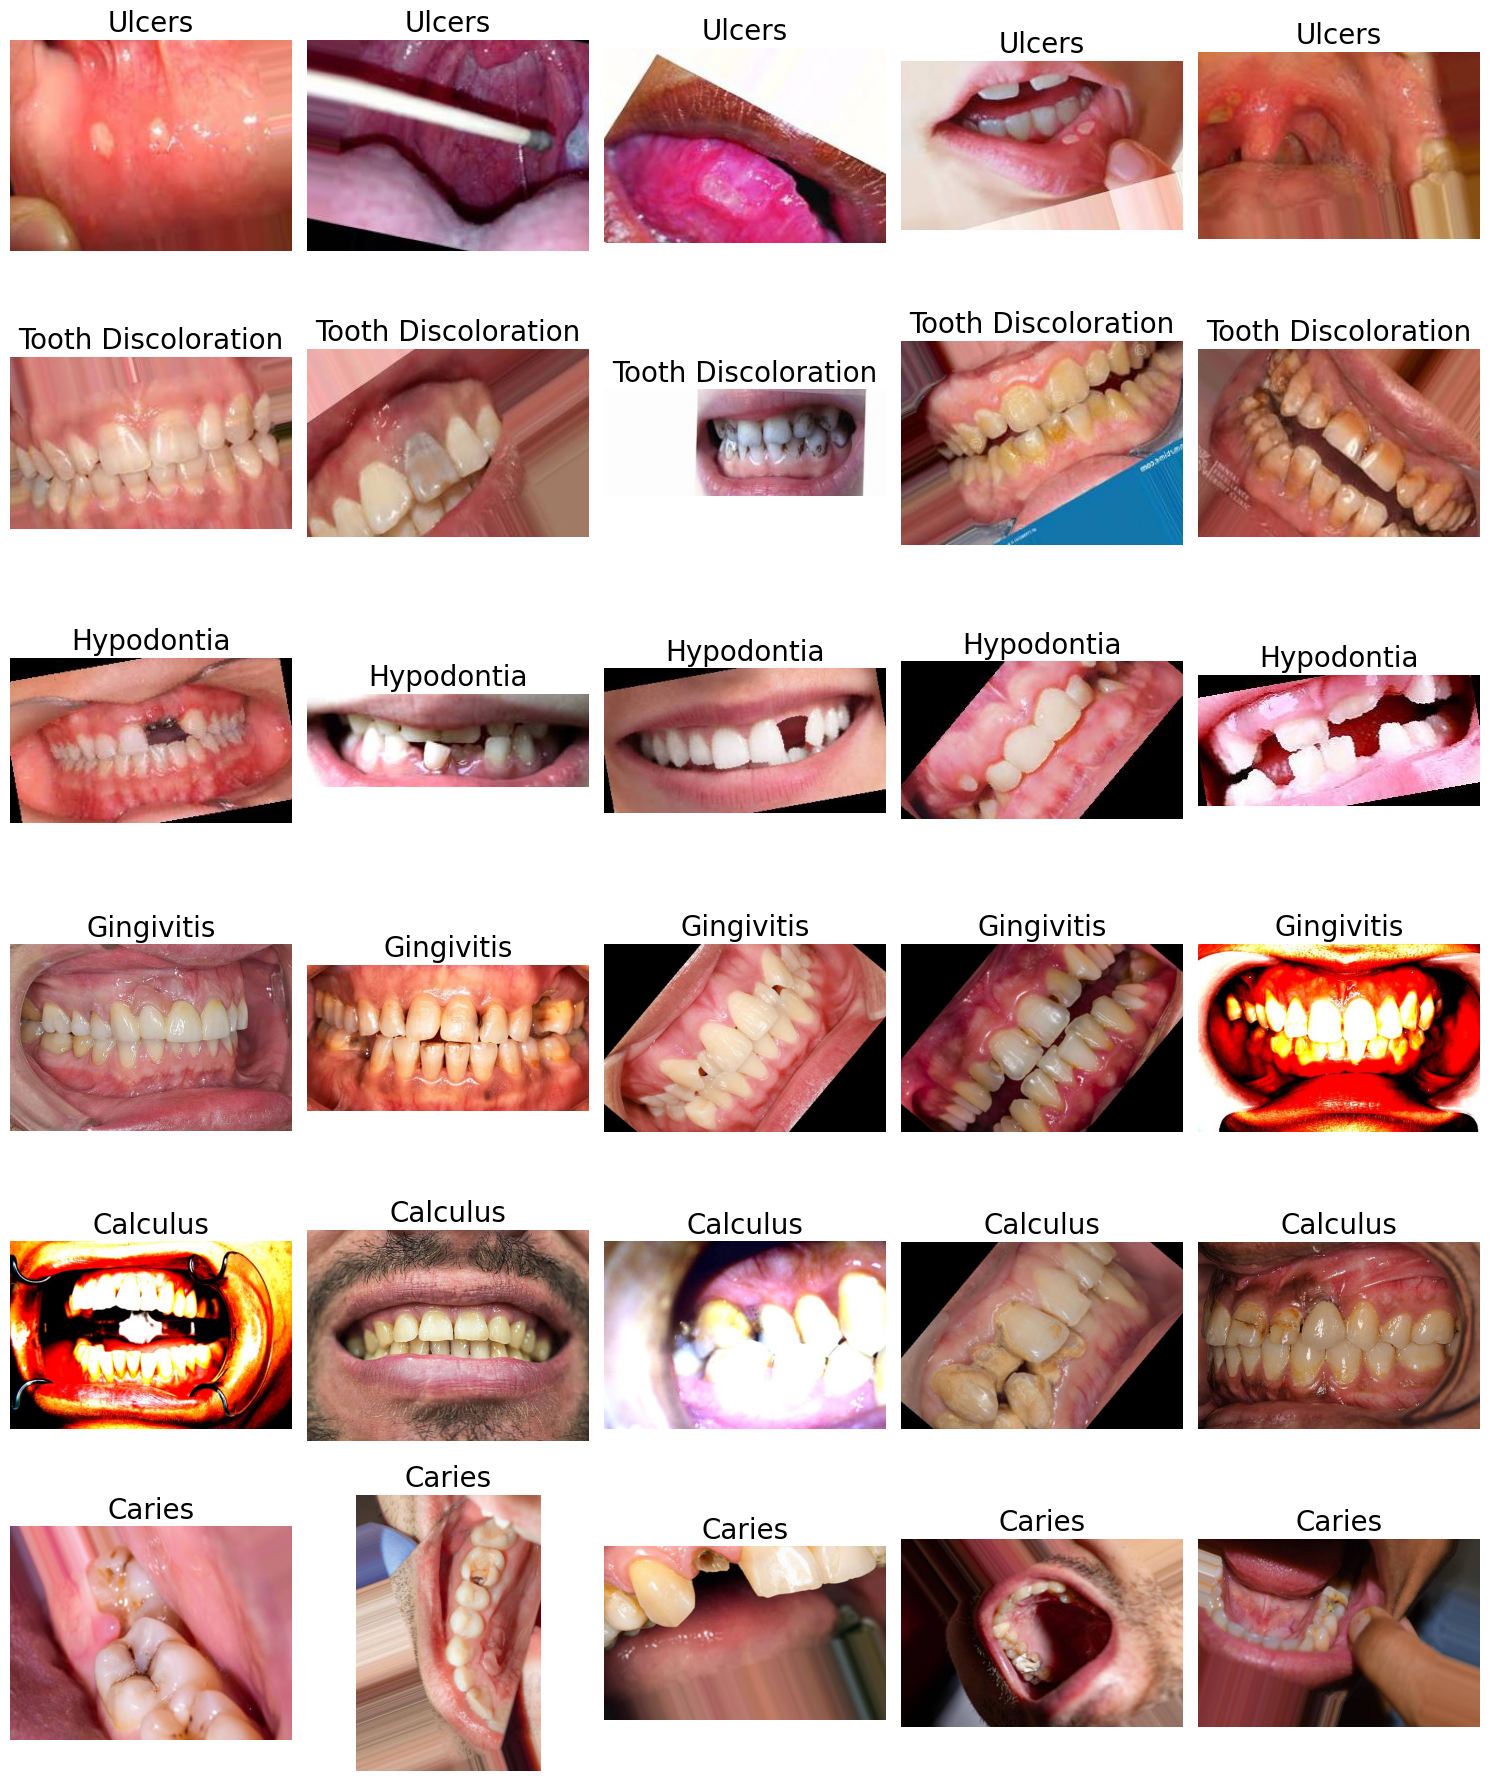

In [ ]:
# Displaying random images for each class
import random

class_dir = '/kaggle/working/train'
classes = os.listdir(class_dir)

plt.figure(figsize=(15, len(classes) * 3))
num_images = 5  # number images to show per class

for i, class_name in enumerate(classes):
    class_path = os.path.join(class_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # take random image for per 
    sample_images = random.sample(image_files, min(num_images, len(image_files)))

    for j, image in enumerate(sample_images):
        full_image_path = os.path.join(class_path, image)
        img = Image.open(full_image_path)

        # subplot(row, col, index)
        plt.subplot(len(classes), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')

        plt.title(class_name, fontsize=20)

plt.tight_layout()
plt.show()


# Data Augmentation & Preparing Model

In [53]:
train_dir='/kaggle/working/train'
val_dir='/kaggle/working/val'
test_dir='/kaggle/working/test'

# Parameters
image_size = (128, 128)
batch_size = 16
num_epochs = 15

# Augmentation
train_transform=transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
# Dataset
train_dataset=ImageFolder(train_dir,transform=train_transform)
val_dataset=ImageFolder(val_dir,transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# DataLoader
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Build Model (ResNet18)

In [54]:
num_classes=len(train_dataset.classes)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model=resnet18(weights=True)
        self.model.fc=nn.Linear(self.model.fc.in_features,num_classes)

    def forward(self,x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().to(device)

optimizer=Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Model Evaluation 📉


In [55]:
# Early stopping
best_val_loss = float('inf')

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    #  Training
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * inputs.size(0)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    train_loss = total_train_loss / len(train_dataset)
    train_acc = correct_train / total_train
    

    #  Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * inputs.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_loss = total_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # show output
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    

Epoch [1/15] Train Loss: 0.9444 | Val Loss: 1.0052 | Val Acc: 0.6656
Epoch [2/15] Train Loss: 0.6605 | Val Loss: 0.8063 | Val Acc: 0.7070
Epoch [3/15] Train Loss: 0.5195 | Val Loss: 0.4999 | Val Acc: 0.7875
Epoch [4/15] Train Loss: 0.4733 | Val Loss: 0.5113 | Val Acc: 0.7951
Epoch [5/15] Train Loss: 0.4315 | Val Loss: 0.4717 | Val Acc: 0.8066
Epoch [6/15] Train Loss: 0.3845 | Val Loss: 0.5046 | Val Acc: 0.8161
Epoch [7/15] Train Loss: 0.3558 | Val Loss: 0.5418 | Val Acc: 0.7999
Epoch [8/15] Train Loss: 0.3237 | Val Loss: 0.4385 | Val Acc: 0.8499
Epoch [9/15] Train Loss: 0.3136 | Val Loss: 0.4875 | Val Acc: 0.8232
Epoch [10/15] Train Loss: 0.2816 | Val Loss: 0.4139 | Val Acc: 0.8609
Epoch [11/15] Train Loss: 0.2765 | Val Loss: 0.5517 | Val Acc: 0.8132
Epoch [12/15] Train Loss: 0.2579 | Val Loss: 0.4099 | Val Acc: 0.8618
Epoch [13/15] Train Loss: 0.2582 | Val Loss: 0.4549 | Val Acc: 0.8237
Epoch [14/15] Train Loss: 0.2334 | Val Loss: 0.5002 | Val Acc: 0.8261
Epoch [15/15] Train Loss: 0.2

In [56]:
# Test the model
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8477


# Plot loss and accuracy 📉

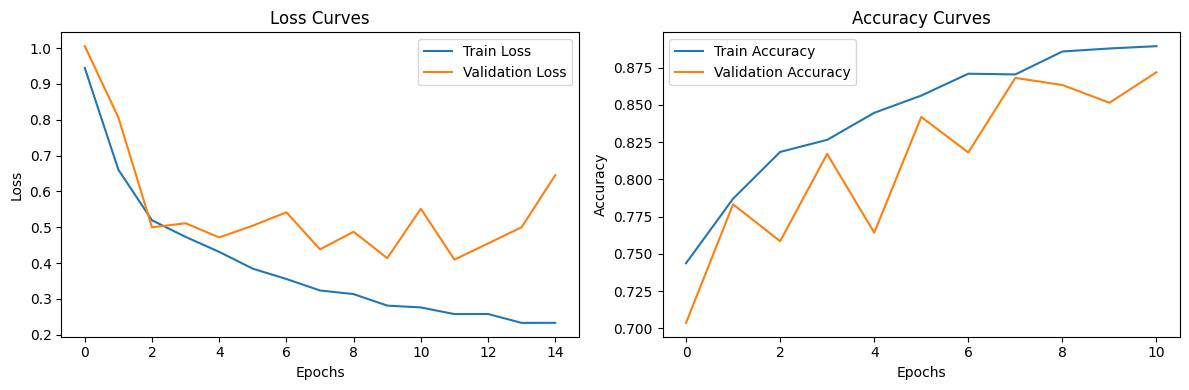

In [ ]:
# Plotting loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotting loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting accuracy
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

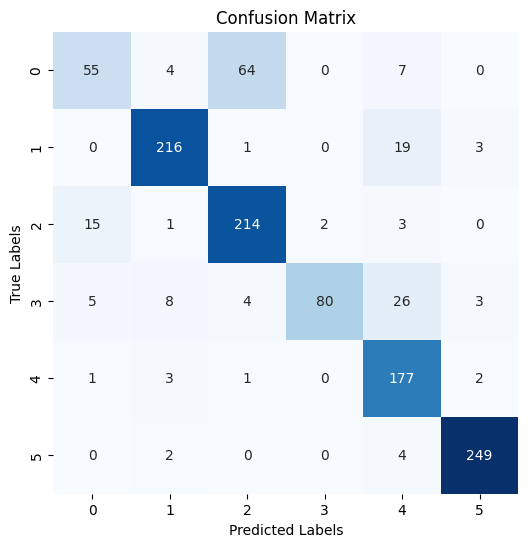

In [58]:
# Get predictions for the test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

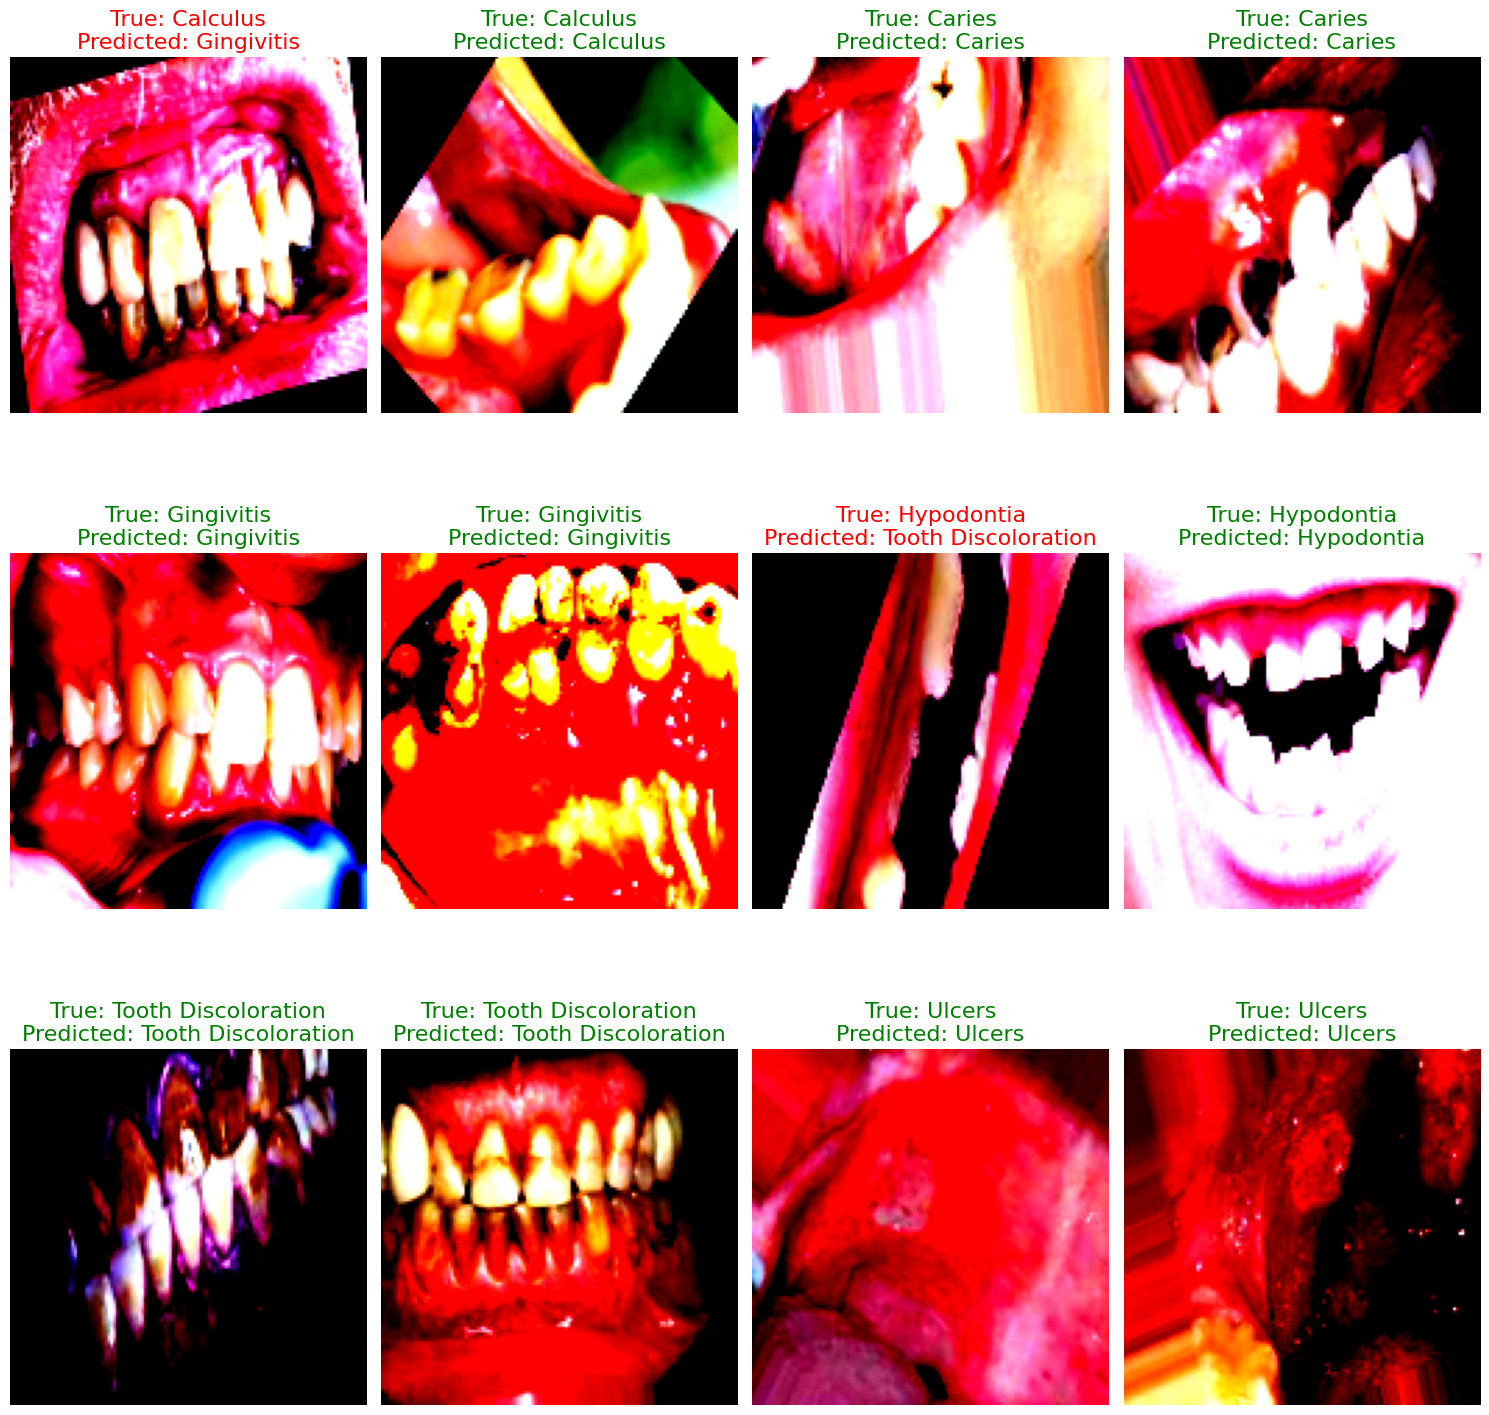

In [59]:
# Set seed for reproducibility
random.seed(42)
class_names = test_dataset.classes

# Function to display random images with true and predicted classes
def display_random__predicted_images(model, test_loader, class_names, num_images_per_class=5):
    model.eval()
    plt.figure(figsize=(15, 30))
    images_so_far = 0
    class_counts = {classname: 0 for classname in class_names}
    shown_images = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                true_class_name = class_names[labels[j].item()]
                predicted_class_name = class_names[preds[j].item()]

                if class_counts[true_class_name] < num_images_per_class and (true_class_name, j) not in shown_images:
                    images_so_far += 1
                    ax = plt.subplot(len(class_names), num_images_per_class * 2, images_so_far)
                    ax.axis('off')
                    if true_class_name == predicted_class_name:
                        title_color = 'green'
                    else:
                        title_color = 'red'
                    ax.set_title(f'True: {true_class_name}\nPredicted: {predicted_class_name}', fontsize=16, color=title_color)
                    plt.imshow(inputs.cpu().data[j].permute(1, 2, 0))
                    class_counts[true_class_name] += 1
                    shown_images.append((true_class_name, j))

                if images_so_far >= len(class_names) * num_images_per_class:
                    return

# Display random predicted images
display_random__predicted_images(model, test_loader, class_names, num_images_per_class=2)
plt.tight_layout()
plt.show()